In [1]:
import xarray as xr
import numpy as np
from matplotlib import pyplot as plt
from xhistogram.xarray import histogram

In [2]:
# Load the data
rootdir = '/archive/gam/ESM4/DECK/ESM4_piControl_D/gfdl.ncrc4-intel16-prod-openmp/'
runname = '11'
filename = '08990101.ocean_daily.nc'
ds = xr.open_dataset(rootdir+runname+'/history/'+filename)#.isel(time=0)#.sel(xh=slice(-40,-20),yh=slice(0,20))
# filename_rho2 = '08990101.ocean_month_rho2.nc'
# rho2_i = xr.open_dataset(rootdir+runname+'/history/'+filename_rho2).rho2_i
filename_grid = '08990101.ocean_static_no_mask_table.nc'
grid = xr.open_dataset(rootdir+runname+'/history/'+filename_grid).sel(xh=-40,yh=0,method='nearest')

/nbhome/gam/miniconda/envs/mom6-clean/lib/python3.8/site-packages/xarray/coding/times.py:426: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


### interpolation (gmacgilchrist)

In [57]:
# Reassign the vertical coordinate to just be the k index
nk = len(ds['zl'])
ds_now = ds.assign_coords(zl=np.linspace(1,nk,nk))
terms = ['T_advection_xy','temp','thkcello']
ds_now = ds_now[terms]
# Assign a k-value for the interfaces
z_i = np.linspace(0.5,nk+0.5,nk+1)
# I want to take each of those layers and split it up into X chunks
# Develop a "super" k-grid
X = 4
z_i_target = np.linspace(0.5,nk+0.5,nk*X+1)
# Get the value of the layers on the super grid
z_l_target = 0.5*(z_i_target[1:]+z_i_target[:-1])

# Interpolate the intensive quantities
temp = ds_now['temp'].interp({'zl':z_l_target},method='linear',kwargs={'fill_value':'extrapolate'})
# Chunk up the extensive quantities
var = 'T_advection_xy'
new = xr.zeros_like(temp)
for k in range(len(ds_now['zl'])):
    index = np.arange(k*X,k*X+X)
    zl_ones = xr.DataArray(np.ones(shape=(X)),dims=['zl'],coords={'zl':z_l_target[index]})
    v = zl_ones*(ds_now[var].isel(zl=k)/X)
    new.loc[{'zl':z_l_target[index]}]=v.transpose('time','zl','yh','xh')


In [16]:
def calc_refine(da,refineby,variable_type,vertc='zl'):
    nk = len(da[vertc])
    # Set vertical coordinate to layer index
    da=da.assign_coords({vertc:np.linspace(1,nk,nk)})
    # Assign a k-value for the interfaces
    k_i = np.linspace(0.5,nk+0.5,nk+1)
    # Develop the super grid, based on the interfaces
    z_i_target = np.linspace(0.5,nk+0.5,nk*refineby+1)
    # Get the value of the layers on the super grid
    z_l_target = 0.5*(z_i_target[1:]+z_i_target[:-1])
    
    # Refine the grid
    if variable_type == 'intensive':
        da_refined = da.interp({'zl':z_l_target},method='linear',kwargs={'fill_value':'extrapolate'})
    if variable_type == 'extensive':
        da_refined = xr.zeros_like(da.interp({'zl':z_l_target}))
        for k in range(nk):
            chunk = da.isel({vertc:k})/refineby
            index = np.arange(k*refineby,(k+1)*refineby)
            da_refined.loc[{vertc:z_l_target[index]}]=chunk
    
    return da_refined

da_refined = calc_refine(ds_now['temp'],refineby=2,variable_type='intensive',vertc='zl')

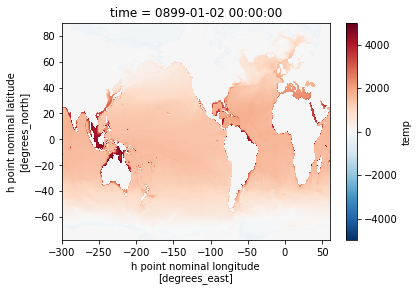

In [18]:
da_refined.sum(dim='zl').plot()

### xlayers (cspencerjones)

In [6]:
from xlayers import finegrid, layers
from xlayers.core import layers_numpy

terms = ['T_advection_xy','temp','thkcello']
ds_now = ds[terms]

In [19]:
z_i = xr.concat([xr.zeros_like(ds['thkcello'].isel(zl=0)),ds['thkcello'].cumsum(dim='zl')],dim='zl')
lev_bnds = np.zeros(shape=(len(z_i)-1,2))
for z in range(len(z_i)-1):
    lev_bnds[z,0] = z_i.isel(zl=z).values
    lev_bnds[z,1] = z_i.isel(zl=z+1).values
levs = np.mean(lev_bnds,axis=1)

In [21]:
def finegrid_metrics(levs,lev_bnds):
    drF = np.diff(lev_bnds,axis=1)
    drC = np.concatenate((np.array([levs[0]]),np.diff(levs,axis=0),np.array([lev_bnds[-1,-1]-levs[-1]])))
    return(drF,drC)

In [22]:
# z_i = xr.concat([xr.zeros_like(ds['thkcello'].isel(zl=0)),ds['thkcello'].cumsum(dim='zl')],dim='zl')
# z_i = z_i.rename({'zl':'zi'})
# z_i_vals = z_i.values
# z_l_vals = 0.5*(z_i_vals[:,:,:-1]+z_i_vals[:,:,1:])
# z_l = xr.DataArray(z_l_vals,dims=['yh','xh','zl'],coords={'xh':z_i.xh,'yh':z_i.yh,'zl':ds['zl']})

In [32]:
fine_drf,fine_drc = finegrid_metrics(levs,lev_bnds)
# print(finegrid.finegrid(np.squeeze(fine_drf), np.squeeze(fine_drc),[fine_drf.size,10]))

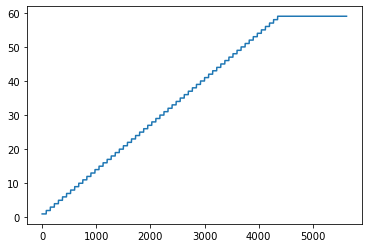

In [33]:
#Here we call the first xlayers function, finegrid, that calculates key parameters for rebinning the data
drf_finer, mapindex, mapfact, cellindex = finegrid.finegrid(np.squeeze(fine_drf),np.squeeze(fine_drc),[fine_drf.size,10])
plt.plot(cellindex)

In [50]:
#here we define the new coordinate system
thetalayers = np.linspace(-3,31,80)

#this is the main function in xlayers: it is being applied to a single column here for demonstration purposes
xh_in_theta = layers.layers_1(ds_now.T_advection_xy.values, ds_now.temp.values,
                     thetalayers, mapfact, mapindex, cellindex, drf_finer)
h_in_theta = layers.layers_1(xr.ones_like(ds_now.T_advection_xy).values, ds_now.temp.values,
                     thetalayers, mapfact, mapindex, cellindex, drf_finer)
x_in_theta = xh_in_theta/h_in_theta

<ipython-input-50-e5a086963c02>:9: RuntimeWarning: invalid value encountered in true_divide
  x_in_theta = xh_in_theta/h_in_theta


### vertical_coordinates (jbusecke)

In [5]:
from xarrayutils import vertical_coordinates as vc
terms = ['thkcello','o2h_tendency','o2_advection_xy','o2h_tendency_vert_remap','o2_dfxy_cont_tendency','o2_vdiffuse_impl','jo2']
# terms = ['rhopot2','osalttend','S_advection_xy','Sh_tendency_vert_remap','boundary_forcing_salt_tendency','osaltdiff','osaltpmdiff']
ds_now = ds[terms].squeeze() # .sel(xh=slice(-30,-20)).sel(yh=0,method='nearest')

In [11]:
# Get the depth of the layers on the native grid
z_i = xr.concat([xr.zeros_like(ds_now['thkcello'].isel(zl=0)),ds_now['thkcello'].cumsum(dim='zl')],dim='zl')
z_i = z_i.rename({'zl':'zi'})
z_i_vals = z_i.values
z_l_vals = 0.5*(z_i_vals[:,:,:,:-1]+z_i_vals[:,:,:,1:])
# z_l_vals = 0.5*(z_i_vals[:,:-1]+z_i_vals[:,1:])
# z_l_vals = 0.5*(z_i_vals[:-1]+z_i_vals[1:])
z_l = xr.DataArray(z_l_vals,dims=['time','yh','xh','zl'],coords={'time':z_i.time,'xh':z_i.xh,'yh':z_i.yh,'zl':ds_now.zl})
# z_l = xr.DataArray(z_l_vals,dims=['xh','zl'],coords={'xh':z_i.xh,'zl':ds_now.zl})
# z_l = xr.DataArray(z_l_vals,dims=['zl'],coords={'zl':ds_now.zl})

ds_now['depth_i']=z_i
ds_now['depth_l']=z_l

#### Remap to density coords

In [79]:
# Get depths of target density surfaces
maxval = ds_now['rhopot2'].max(xr.ALL_DIMS).values
rho2_i_vals = xr.concat([rho2_i,xr.DataArray(maxval,coords={'rho2_i':maxval})],dim='rho2_i')
rho2_i_depth = vc.linear_interpolation_regrid(z = ds_now['depth_l'],
                                           data = ds_now['rhopot2'],
                                           target_values = rho2_i_vals,
                                           z_bounds = ds_now['depth_i'],
                                           target_value_dim = 'rho2_i',
                                           z_bounds_dim='zi',
                                           z_dim='zl')

/nbhome/gam/miniconda/envs/mom6/lib/python3.7/site-packages/scipy/interpolate/interpolate.py:610: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


In [80]:
ds_now_remap=xr.Dataset()
for term in terms[2:]:
    print(term)
    ds_now_remap[term] = vc.conservative_remap(ds_now[term],z_bnds_source=ds_now['depth_i'], z_bnds_target=rho2_i_depth,
                                   z_dim='zl', z_bnd_dim='zi', z_bnd_dim_target='regridded', mask=True)

osalttend
S_advection_xy
Sh_tendency_vert_remap
boundary_forcing_salt_tendency
osaltdiff
osaltpmdiff


In [81]:
prof = (ds_now_remap*grid.areacello).sum(['xh','yh'])
tendsum = xr.zeros_like(prof[terms[2]])
for term in terms[3:]:
    tendsum += prof[term]

(-0.001, 0.001)

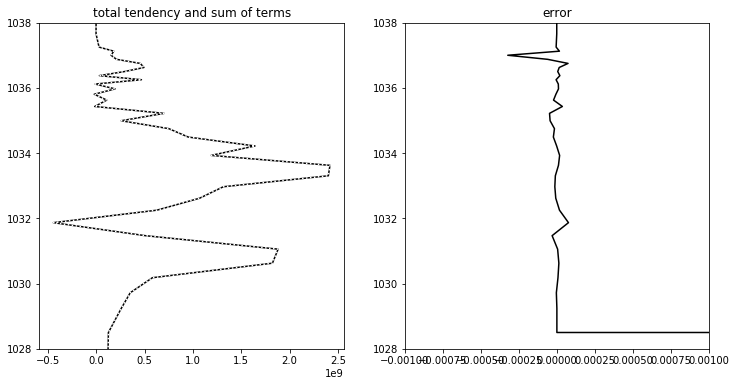

In [86]:
fig,ax = plt.subplots(figsize=(12,6),ncols=2)
ax[0].plot(prof[terms[2]].transpose(),0.5*(rho2_i_vals.values[1:]+rho2_i_vals.values[:-1]),'k-',label='tendency');
ax[0].plot(tendsum.transpose(),0.5*(rho2_i_vals.values[1:]+rho2_i_vals.values[:-1]),'w:',label='sum of terms');
ax[0].set_title('total tendency and sum of terms')
ax[0].set_ylim([1028,1038])
# ax[0].legend()
ax[1].plot((prof[terms[2]]-tendsum).transpose(),0.5*(rho2_i_vals.values[1:]+rho2_i_vals.values[:-1]),'k',label='error');\
ax[1].set_title('error')
ax[1].set_ylim([1028,1038])
ax[1].set_xlim([-1E-3,1E-3])
# ax[1].legend()

#### Remap to high-res depth levels, then histogram

In [27]:
depth_i_target_vals = np.arange(0,6511,10)
depth_i_target = xr.DataArray(depth_i_target_vals,dims=['zi_target'],coords={'zi_target':depth_i_target_vals})
depth_i_target = depth_i_target*xr.ones_like(ds_now['thkcello'].isel(zl=0).squeeze())

In [28]:
ds_now_remap=xr.Dataset()
for term in terms[2:3]:
    print(term)
    ds_now_remap[term] = vc.conservative_remap(ds_now[term].isel(time=0),z_bnds_source=ds_now['depth_i'].isel(time=0), z_bnds_target=depth_i_target.isel(time=0),
                                   z_dim='zl', z_bnd_dim='zi', z_bnd_dim_target='zi_target', mask=True)

o2_advection_xy


MemoryError: Unable to allocate 151. GiB for an array with shape (576, 720, 75, 651) and data type float64

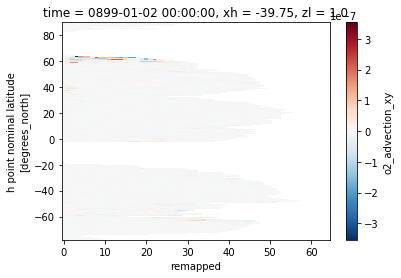

In [26]:
ds_now_remap['o2_advection_xy'].isel(time=0).sel(xh=-40,method='nearest').plot()